In [2]:
from langgraph.graph import StateGraph
import gradio as gr
from utils.tools import GraphState  # 图结构数据类型声明
from langgraph.graph import END
from utils.function_tools import route_question, call_model, call_model_SQL_prompt, call_model_SQL
from utils.rag_text import call_model_raglaw
from langgraph.checkpoint.memory import MemorySaver
from utils.enhencement_functions import route_question_enhencement
from utils.noun_retriever import noun_retriever_prompt


def law_question_prompt(state):
    question = state["question"]
   
    prompt_SQL = '必须用中文回答'
    new_question = question + '，' + prompt_SQL

    return {"question": new_question}


def route_question_law(state):
    return "clear_question"


def call_model_filter(state):
    question = state["generation"]
    prompt_SQL = """请根据问题和检索信息，把回答整理成一个过滤后的答案，
    即回答出问题需要的信息，
    假如无法做到，就回答请参考上海市交通交易系统的官方网站，
    回答中不要提到问题的信息，只要回答的部分即可
    """
    new_question = question + '，' + prompt_SQL
    messages = [HumanMessage(content=new_question)]
    response = llm.invoke(messages)
    return {"generation": response.content}


workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("answer_directly", call_model)  # web search
workflow.add_node("retrieve_SQL_prompt", call_model_SQL_prompt)
# workflow.add_node("retrieve_SQL", call_model_SQL_vanna)  # retrieve， 第一种vanna方案
workflow.add_node("retrieve_SQL", call_model_SQL)  # 第二种SQL查询方案，用langchain自带方法,方案切换只需要注释掉其中一个节点即可

# workflow.add_node("SQL_enhencement", label_predict_SQL)
workflow.add_node("SQL_enhencement", noun_retriever_prompt)
workflow.add_node("enhencement_processing", call_model)
workflow.add_node("information_filter", call_model_filter)

# Define three four nodes
workflow.add_node("law_question", law_question_prompt) # 替换为正确的函数

workflow.add_node("retrieve_law", call_model_raglaw)
workflow.add_node("meaning_large_retrieve", call_model_raglaw) #替换为正确的函数
workflow.add_node("similarity_retrieve", call_model_raglaw)


# Define the edges
workflow.add_edge("answer_directly", END)
# workflow.add_edge("retrieve_SQL_prompt", "retrieve_SQL")
workflow.add_edge("retrieve_SQL", END)

workflow.add_edge("retrieve_law", END)
workflow.add_edge("meaning_large_retrieve", END)
workflow.add_edge("similarity_retrieve", END)
workflow.add_edge("SQL_enhencement", "enhencement_processing")
workflow.add_edge("enhencement_processing", "information_filter")
workflow.add_edge("information_filter", END)



# Build graph
workflow.set_conditional_entry_point(
    route_question,
    {
        "answer_directly": "answer_directly",
        "vectorstore": "retrieve_SQL_prompt",
        "law_query": "law_question",
    },
)


workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "retrieve_SQL_prompt",
    # Next, we pass in the function that will determine which node is called next.
    route_question_enhencement,
    {
        "no_enhencement": "retrieve_SQL",
        "enhencement": "SQL_enhencement"
    
    },
)

workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "law_question",

    
    # Next, we pass in the function that will determine which node is called next.
    route_question_law,
    {
        "clear_question": "retrieve_law",
        "law_details": "meaning_large_retrieve",
        "law_examples": "similarity_retrieve"

    },
)


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
C:\Users\30387\anaconda3\envs\shanghaiproject\lib\site-packages\langsmith\client.py:354: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [3]:
graph = workflow.compile()

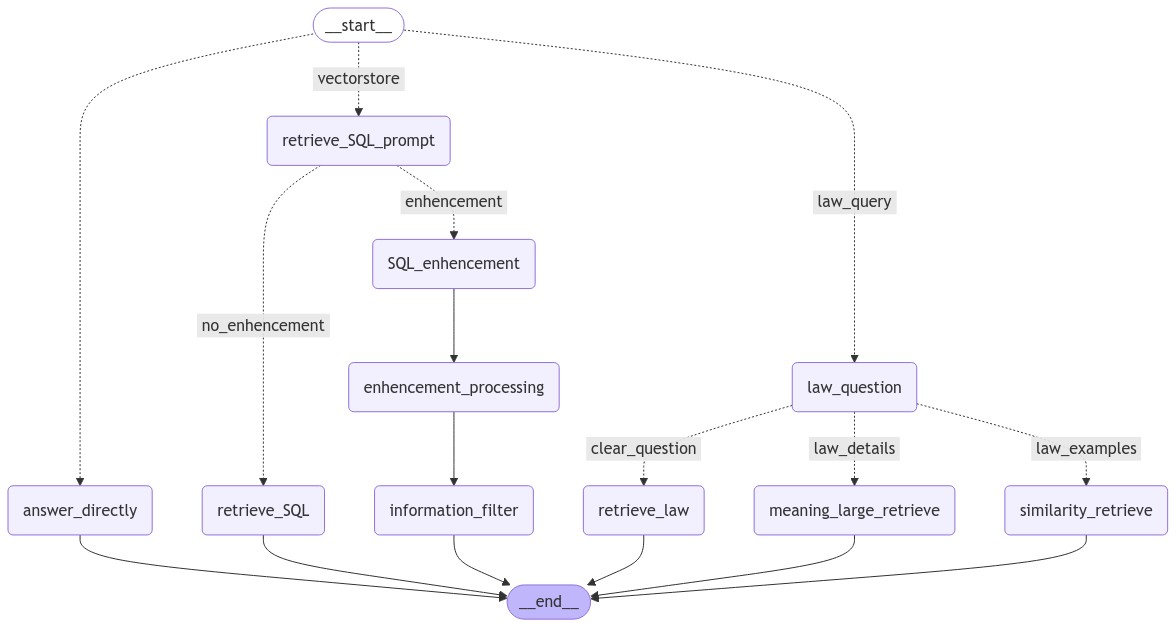

In [4]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))